In [1]:
import Model
import tensorflow as tf
import keras
import os
import re
import hashlib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import SpeechGenerator
import librosa
#from keras import losses

#from extractMFCC import computeFeatures, computeFeatures1
#from addNoise import addNoise
print(tf.__version__)

Using TensorFlow backend.


1.13.1


In [2]:
testWAVs = pd.read_csv('Dataset/testing_list.txt', sep=" ", header=None)[0].tolist()
valWAVs  = pd.read_csv('Dataset/validation_list.txt', sep=" ", header=None)[0].tolist()

for idx, item in enumerate(testWAVs):
    testWAVs[idx] = "Dataset/" + testWAVs[idx]

for idx, item in enumerate(valWAVs):
    valWAVs[idx] = "Dataset/" + valWAVs[idx]

In [3]:
DictCategs = {'nine' : 1, 'yes' : 2, 
                         'no' : 3, 'up' : 4, 'down' : 5, 'left' : 6, 'right' : 7, 'on' : 8, 'off' : 9, 'stop' : 10, 'go' : 11,
                         'zero' : 12, 'one' : 13, 'two' : 14, 'three' : 15, 'four' : 16, 'five' : 17, 'six' : 18, 
                         'seven' : 19,  'eight' : 20, 'backward':0, 'bed':0, 'bird':0, 'cat':0, 'dog':0,
                         'follow':0, 'forward':0, 'happy':0, 'house':0, 'learn':0, 'marvin':0, 'sheila':0, 'tree':0,
                         'visual':0, 'wow':0}
nCategs = 21

In [4]:
allWAVs  = []
for root, dirs, files in os.walk('Dataset/'):
    if root != "Dataset/_background_noise_":
        allWAVs += [root+'/'+ f for f in files if f.endswith('.wav')]
trainWAVs = list( set(allWAVs)-set(valWAVs)-set(testWAVs) )

In [5]:
print(len(trainWAVs))
print(len(valWAVs))
print(len(testWAVs))

84843
9981
11005


In [6]:
def _getFileCategory(file, catDict):
    """
    Receives a file with name Dataset/<cat>/<filename> and returns an integer that is catDict[cat]
    """
    categ = os.path.basename(os.path.dirname(file))
    return catDict.get(categ,0)

In [7]:
#get categories
testWAVlabels = [_getFileCategory(f, DictCategs) for f in testWAVs]
valWAVlabels = [_getFileCategory(f, DictCategs) for f in valWAVs]
trainWAVlabels = [_getFileCategory(f, DictCategs) for f in trainWAVs]

In [8]:
print(len(trainWAVlabels))
print(len(valWAVlabels))
print(len(testWAVlabels))
#print(trainWAVs[60000])
#print(trainWAVlabels[60000])

84843
9981
11005


In [9]:
"""def load_and_preprocess_data(file_name):
    # Required by tensorflow (strings are passed as bytes)
    # tf.strings.as_string(...)
    file_name = file_name.numpy()
    file_name = file_name.decode("utf-8") 
    #print(file_name)
    #print(type(file_name))

    # Load data
    feats = computeFeatures(file_name)
    # Normalize
    mean = np.mean(feats, axis = 0)
    stv = np.std(feats, axis = 0)
    diff = np.subtract(feats, mean)
    feats = np.divide(diff, stv)

    return feats.astype(np.float32)

# example:

feats = load_and_preprocess_data(trainWAVs[25])
feats = np.transpose(feats)

plt.figure(figsize=(17,6))
plt.pcolormesh(feats)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()
print(trainWAVlabels[25])
"""

'def load_and_preprocess_data(file_name):\n    # Required by tensorflow (strings are passed as bytes)\n    # tf.strings.as_string(...)\n    file_name = file_name.numpy()\n    file_name = file_name.decode("utf-8") \n    #print(file_name)\n    #print(type(file_name))\n\n    # Load data\n    feats = computeFeatures(file_name)\n    # Normalize\n    mean = np.mean(feats, axis = 0)\n    stv = np.std(feats, axis = 0)\n    diff = np.subtract(feats, mean)\n    feats = np.divide(diff, stv)\n\n    return feats.astype(np.float32)\n\n# example:\n\nfeats = load_and_preprocess_data(trainWAVs[25])\nfeats = np.transpose(feats)\n\nplt.figure(figsize=(17,6))\nplt.pcolormesh(feats)\n\nplt.title(\'Spectrogram visualization\')\nplt.ylabel(\'Frequency\')\nplt.xlabel(\'Time\')\n\nplt.show()\nprint(trainWAVlabels[25])\n'

In [10]:
"""def create_dataset(file_names, labels, batch_size, shuffle, cache_file=None):
    
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
    
    # Map the load_and_preprocess_data function
    py_func = lambda file_name, label: (tf.py_function(load_and_preprocess_data, [file_name], Tout=tf.float32), label)
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())
    
    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)
    
    # Shuffle    
    if shuffle:
        dataset = dataset.shuffle(len(file_names))
        
    # Repeat the dataset indefinitely
    dataset = dataset.repeat()
    
    # Correct input shape for the network
    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, 1), label))
    
    # Batch
    dataset = dataset.batch(batch_size=batch_size)
    
    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)
    
    return dataset
"""

'def create_dataset(file_names, labels, batch_size, shuffle, cache_file=None):\n    \n    # Create a Dataset object\n    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))\n    \n    # Map the load_and_preprocess_data function\n    py_func = lambda file_name, label: (tf.py_function(load_and_preprocess_data, [file_name], Tout=tf.float32), label)\n    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())\n    \n    # Cache dataset\n    if cache_file:\n        dataset = dataset.cache(cache_file)\n    \n    # Shuffle    \n    if shuffle:\n        dataset = dataset.shuffle(len(file_names))\n        \n    # Repeat the dataset indefinitely\n    dataset = dataset.repeat()\n    \n    # Correct input shape for the network\n    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, 1), label))\n    \n    # Batch\n    dataset = dataset.batch(batch_size=batch_size)\n    \n    # Prefetch\n    dataset = dataset.prefetch(buffer_size=1)\n    \n    return dataset\n'

In [11]:
"""batch_size = 32
train_dataset = create_dataset(trainWAVs, 
                               trainWAVlabels, 
                               batch_size=batch_size, 
                               shuffle=True,
                               cache_file='train_cache')

val_dataset = create_dataset(valWAVs, 
                             valWAVlabels,
                             batch_size=batch_size, 
                             shuffle=False,
                             cache_file='val_cache')

train_steps = int(np.ceil(len(trainWAVs)/batch_size))
val_steps = int(np.ceil(len(valWAVs)/batch_size))
"""

"batch_size = 32\ntrain_dataset = create_dataset(trainWAVs, \n                               trainWAVlabels, \n                               batch_size=batch_size, \n                               shuffle=True,\n                               cache_file='train_cache')\n\nval_dataset = create_dataset(valWAVs, \n                             valWAVlabels,\n                             batch_size=batch_size, \n                             shuffle=False,\n                             cache_file='val_cache')\n\ntrain_steps = int(np.ceil(len(trainWAVs)/batch_size))\nval_steps = int(np.ceil(len(valWAVs)/batch_size))\n"

In [19]:
model = Model.AttentionModel(21, 99, 39, use_GRU = True)
adam = tf.train.AdamOptimizer(learning_rate=0.00000001,  
                                beta1=0.9,
                                beta2=0.999,
                                epsilon=1e-07,
                                use_locking=False,
                                name='Adam')
model.compile(optimizer=adam,
              loss= tf.losses.softmax_cross_entropy,
              metrics=[keras.metrics.categorical_accuracy, ])

In [13]:
train = np.asarray(trainWAVs)
labels = np.asarray(trainWAVlabels)

for i in range(len(trainWAVs)):
    #y, sr = librosa.load(trainWAVs[i], sr=16000)
   
    #if we want to write the file later
    #librosa.output.write_wav('file.wav', y, sr, norm=False)
      
    #np.save(trainWAVs[i]+'.npy', y)
    train[i] = trainWAVs[i] + '.npy'


In [14]:
print(train[15000])
print(trainWAVlabels[15000])

Dataset/go/3bb68054_nohash_0.wav.npy
11


In [15]:
trainGen = SpeechGenerator.SpeechGen(train, trainWAVlabels, shuffle=True)

#print(trainGen.labels[:10])
#print(train[30:50])


Epoch 1/1
1325/1325 [==============================] - 2439s 2s/step - loss: nan - categorical_accuracy: 0.9721


/home/jupyter/.local/lib/python3.5/site-packages/keras/engine/saving.py:118: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


KeyError: 'val_loss'

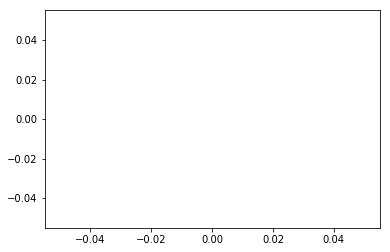

In [20]:
num_epochs = 1
history = model.fit_generator(trainGen, epochs=num_epochs)

# Save the model
model.save('my_model.h5')

# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['acc'], label='Train loss')
plt.plot(history.history['val_acc'], label='Val loss')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
trainEval = model.evaluate_generator(trainGen, use_multiprocessing=True, workers=4,verbose=1)

 881/1325 [==================>...........] - ETA: 5:28